In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
# %matplotlib widget

root_dir = "C:\\Users\\Lenovo\\Desktop\\assemblyhelper"

In [2]:
# Load RGB and PCD raw datas
data_path = "assets/exp_data/raw_datas/tool_space1.npy"
img_info = np.load(os.path.join(root_dir, data_path), allow_pickle=True)
color_data = img_info[()]['color']
point_data = img_info[()]['pointcloud']

In [3]:
# Visualize depth and RGB map
depth_map = cv2.normalize(point_data[:, :, 2], None, 0, 255, cv2.NORM_MINMAX)
depth_map = depth_map.astype(np.uint8)
depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2RGB)
color_map = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)

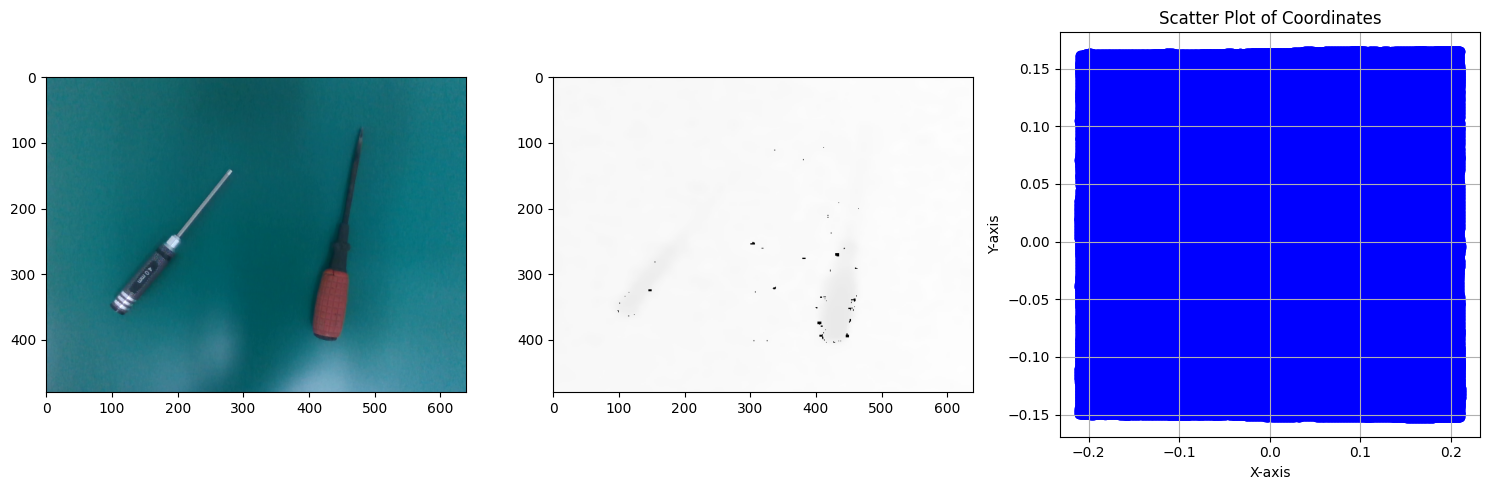

In [4]:
# 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()
ax[0].imshow(color_map)
ax[1].imshow(depth_map)

# visualize xy coordinate
xy_data = point_data[..., :2].reshape((-1,2))
ax[2].scatter(xy_data[:, 0], -xy_data[:, 1], marker='o', color='blue')
ax[2].set_title('Scatter Plot of Coordinates')
ax[2].set_xlabel('X-axis')
ax[2].set_ylabel('Y-axis')
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [5]:
# Load mask data
mask_path = "assets/exp_data/masks/tool_space1.npy"
mask_info = np.load(os.path.join(root_dir, mask_path), allow_pickle=True)

In [6]:
# Get rotated bbox
def draw_rotated_bbox(image, mask, color=(0, 255, 0), thickness=2):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_area = 0
    main_direction = 0
    main_bbox = None
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        center, size, angle = rect
        area = size[0] * size[1]
        if area > max_area:
            max_area = area
            main_direction = angle
            main_bbox = rect
    return main_bbox

In [7]:
obj_mask = mask_info[()]['slotted']
main_bbox = draw_rotated_bbox(color_map, obj_mask)
# plt.imshow(result_image)

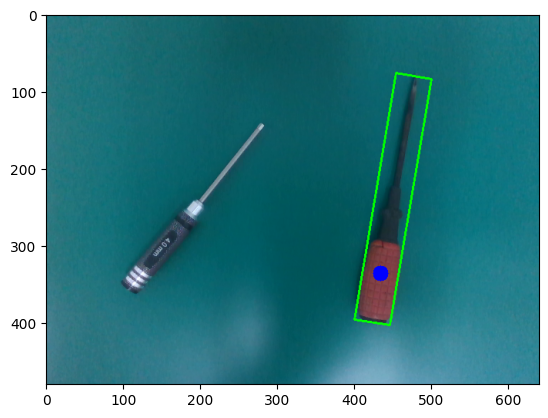

In [8]:
# Calculate grasp point
# @Rect：4.5之后的版本，以bbox的最低点为原点，将x轴顺时针旋转，碰到的第一个边所旋转的角度
# @width：4.5之后的版本，以bbox的最低点为原点，将x轴顺时针旋转，碰到的第一个边为width
# print("Rotation Angle：", main_direction)
# print("Minimum bbox", main_bbox)

(cx, cy), (w, h), r = main_bbox
r_ = r if w < h else -(90-r)
r_rad = r_ * (math.pi / 180)

if w < h:
    x = cx - np.sin(r_rad) * h * 0.3
    y = cy + np.cos(r_rad) * h * 0.3
else:
    x = cx - np.sin(r_rad) * w * 0.3
    y = cy + np.cos(r_rad) * w * 0.3
    
center = [x.astype(int), y.astype(int)]

# visualize bbox and grasp point
tmp_map = copy.deepcopy(color_map)
rotated_box = cv2.boxPoints(main_bbox)
rotated_box = np.intp(rotated_box)
cv2.drawContours(tmp_map, [rotated_box], 0, (0, 255, 0), 2)
cv2.circle(tmp_map, center, 10, [0, 0, 255], -1)
plt.imshow(tmp_map)

In [9]:
def visualize_grasp(image, center):
    bbox = np.array([[-50, 25], [50, 25], [-50, -25], [50, -25]])
    rotation_matrix = np.array([[np.cos(r_rad), -np.sin(r_rad)],
                                [np.sin(r_rad), np.cos(r_rad)]])
    rotated_bbox = np.dot(rotation_matrix, bbox.T).T
    # rotated_bbox = np.dot(bbox, rotation_matrix)
    top_left = center + rotated_bbox[0].astype(int)
    top_right = center + rotated_bbox[1].astype(int)
    bottom_left = center + rotated_bbox[2].astype(int)
    bottom_right = center + rotated_bbox[3].astype(int)
    width_color = (13, 18, 130)
    height_color = (255, 108, 34)
    cv2.line(image, top_left, top_right, width_color,2)
    cv2.line(image, bottom_left, bottom_right, width_color,2)
    cv2.line(image, top_left, bottom_left, height_color,3)
    cv2.line(image, top_right, bottom_right, height_color,3)

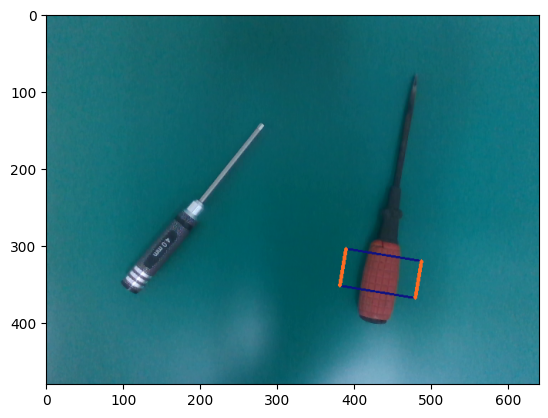

In [10]:
# grasp_map = copy.deepcopy(color_map)
grasp_map = color_map
visualize_grasp(grasp_map, center)
plt.imshow(grasp_map)

In [11]:
# grasp_save_path = "assets/exp_data/results/grasp_tool1_1.jpg"
# cv2.imwrite(os.path.join(root_dir, grasp_save_path), cv2.cvtColor(color_map, cv2.COLOR_RGB2BGR))

In [12]:
# Extract mask region
projected_data = point_data[:, :, :2]
depth_data =  point_data[:, :, 2]
# filter by specific objs mask
masked_proj_cloud = projected_data[obj_mask != 0]
masked_depth = depth_data[obj_mask != 0]
# filter zero points
fliter_data = masked_proj_cloud[masked_depth != 0]
filter_depth = masked_depth[masked_depth != 0]
# print(filter_depth.shape)
# print(fliter_data.shape)
# filter outlier data
min_depth = np.min(filter_depth)
threshold = min_depth + 0.05
indices = np.where(filter_depth < threshold)[0]
fliter_data = fliter_data[indices]
filter_depth = filter_depth[indices]

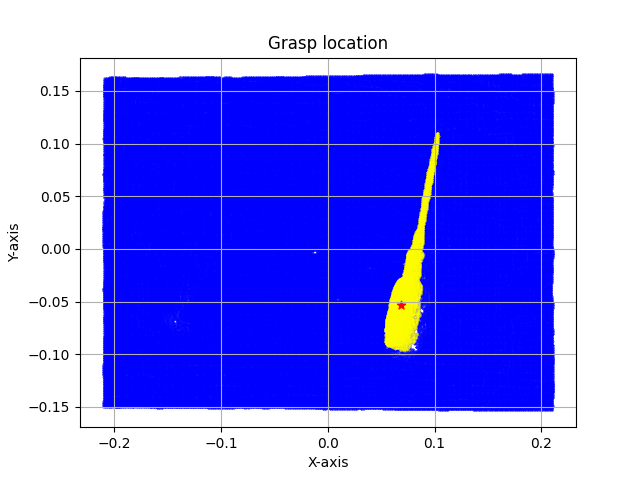

In [13]:
# Get raw data & grasp center in point in PCD
%matplotlib ipympl
xy_data = point_data[..., :2].reshape((-1,2))

plt.scatter(xy_data[:, 0], -xy_data[:, 1], marker='o', color='blue', s=0.1)
plt.scatter(fliter_data[:, 0], -fliter_data[:, 1], marker='o', color='yellow', s=0.1)
plt.scatter(point_data[center[1], center[0], 0], -point_data[center[1], center[0], 1], marker='*', color='red')

plt.title('Grasp location')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()
# grasp_save_path = "assets/exp_data/results/grasp_part1_3.jpg"
# plt.savefig(os.path.join(root_dir, grasp_save_path))

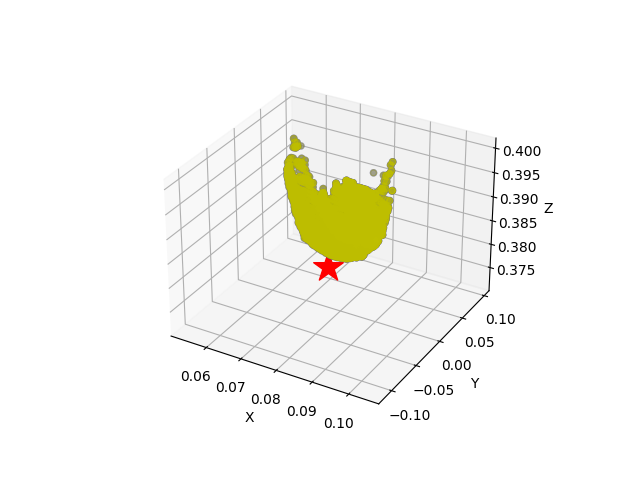

In [18]:
# Visualize object's PCD
%matplotlib ipympl

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# filter pcd by zero & mask region
processed_data = copy.deepcopy(point_data[obj_mask != 0])
processed_data = processed_data[~np.any(processed_data == 0, axis=1)]
ax.scatter(processed_data[:, 0], processed_data[:, 1], processed_data[:, 2], c='b', marker='o', label='pcd')

# filter pcd by min_depth
surface_data = processed_data[indices]
ax.scatter(surface_data[:, 0], surface_data[:, 1], surface_data[:, 2], c='y', marker='o', label='pcd')


grasp_center = point_data[center[1], center[0]]
ax.scatter(grasp_center[0], grasp_center[1], grasp_center[2]-0.003, c='r', marker='*', s=500, label='grasp')

# ax.scatter(point_data[..., 0], -point_data[..., 1], point_data[..., 2], c='b', marker='o', label='grasp')

# set [X,Y,Z] axis on figure
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # hide x-axis' number
# ax.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)  # hide y-axis' number
# ax.tick_params(axis='z', which='both', bottom=False, top=False, labelbottom=False)  # hide z-axis' number

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
ax.grid(True)

# visualize figure
plt.show()